# HW6
## Farrin Marouf Sofian

In [1]:
import cvxopt as cvx
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.spatial.distance as dt
import pandas as pd
from tqdm import tqdm

In [2]:
data_set_images = np.genfromtxt("hw06_images.csv", delimiter = ",")
data_set_labels = np.genfromtxt("hw06_labels.csv", delimiter = "\n")

In [3]:
# training dataset
x_train = data_set_images[0:1000,:]
y_train = data_set_labels[0:1000].astype(int)

#testing dataset
x_test = data_set_images[1000:5000, :]
y_test = data_set_labels[1000:5000].astype(int)


N = x_train.shape[0]
D = x_train.shape[1]
K = np.max(y_train)
N_test = x_test.shape[0]


In [4]:
y_train1 = np.negative(np.ones((N))).astype(int)
y_train2 = np.negative(np.ones((N))).astype(int)
y_train3 = np.negative(np.ones((N))).astype(int)
y_train4 = np.negative(np.ones((N))).astype(int)
y_train5 = np.negative(np.ones((N))).astype(int)

for i in range(N):
    if y_train[i] == 1:
        y_train1[i] = 1
    if y_train[i] == 2:
        y_train2[i] = 1
    if y_train[i] == 3:
        y_train3[i] = 1
    if y_train[i] == 4:
        y_train4[i] = 1
    if y_train[i] == 5:
        y_train5[i] = 1

N_train = len(y_train)
N_test = len(y_test)

In [5]:
y_test1 = np.negative(np.ones((N_test))).astype(int)
y_test2 = np.negative(np.ones((N_test))).astype(int)
y_test3 = np.negative(np.ones((N_test))).astype(int)
y_test4 = np.negative(np.ones((N_test))).astype(int)
y_test5 = np.negative(np.ones((N_test))).astype(int)

for i in range(N_test):
    if y_test[i] == 1:
        y_test1[i] = 1
    elif y_test[i] == 2:
        y_test2[i] = 1
    elif y_test[i] == 3:
        y_test3[i] = 1
    elif y_test[i] == 4:
        y_test4[i] = 1
    elif y_test[i] == 5:
        y_test5[i] = 1


## Distance and Kernel Functions

 $\begin{equation}
    \begin{split}
        d(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= ||\boldsymbol{x}_{i} - \boldsymbol{x}_{j}||_{2} = \sqrt{(\boldsymbol{x}_{i} - \boldsymbol{x}_{j})^{\top} (\boldsymbol{x}_{i} - \boldsymbol{x}_{j})} = \sqrt{\sum\limits_{d = 1}^{D}(x_{id} - x_{jd})^{2}} \\
        k(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= \exp\left(-\dfrac{||\boldsymbol{x}_{i} -\boldsymbol{x}_{j}||_{2}^{2}}{2s^{2}}\right)
    \end{split}
\end{equation}$

In [6]:
# define Gaussian kernel function

#This is different from Gaussian density, this is not normalized
#The integration will not result in 1. there is no 1/2pi coefficient here.
def gaussian_kernel(X1, X2, s): #same for all classes

    D = dt.cdist(X1, X2)
    K = np.exp(-D**2 / (2 * s**2))
    return(K)

In [7]:
def yyk_calculator(y, kernel):
    yyK = np.matmul(y[:,None], y[None,:]) * kernel
                    #(1000, 1)   #(1, 1000)
    return yyK

def get_num_sample(y):
    # get number of samples and number of features
    N_set = len(y)
    return N_set

In [8]:
def train_param(C, x, y):
    # calculate Gaussian kernel
    s = 10 #width parameter of 1
    kernel = gaussian_kernel(x, x, s)
    yyK = yyk_calculator(y, kernel)
    N_set = get_num_sample(y)                
    
    epsilon = 1e-3

    #we are doing optimization with respect to alpha.
    P = cvx.matrix(yyK) #alphas are quadratic. #this is a quadratic programming.
    q = cvx.matrix(-np.ones((N_set, 1)))
    G = cvx.matrix(np.vstack((-np.eye(N_set), np.eye(N_set))))
    h = cvx.matrix(np.vstack((np.zeros((N_set, 1)), C * np.ones((N_set, 1)))))
    A = cvx.matrix(1.0 * y[None,:])
    b = cvx.matrix(0.0)
                    
    # use cvxopt library to solve QP problems
    result = cvx.solvers.qp(P, q, G, h, A, b)
    alpha = np.reshape(result["x"], N_set)
    alpha[alpha < C * epsilon] = 0
    alpha[alpha > C * (1 - epsilon)] = C

    # find bias parameter
    support_indices, = np.where(alpha != 0) #the data points with non zero alpha coefficients are support indecies
    active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
    w0 = np.mean(y[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))
    return [w0, alpha]

In [9]:
y_train_list = [y_train1, y_train2, y_train3, y_train4, y_train5]
C_list = [0.1,1, 10, 100, 1000]


In [10]:
all_params = []
for y in y_train_list:
    current_param = []
    for c in C_list:
        current_param.append(train_param(c, x_train, y))
    all_params.append(current_param)

     pcost       dcost       gap    pres   dres
 0: -1.3936e+02 -2.2047e+02  7e+03  3e+01  3e-15
 1: -3.4801e+01 -2.0264e+02  4e+02  9e-01  3e-15
 2: -2.8151e+01 -7.9601e+01  5e+01  1e-15  1e-15
 3: -3.1266e+01 -4.3423e+01  1e+01  2e-16  1e-15
 4: -3.2572e+01 -3.9120e+01  7e+00  4e-16  1e-15
 5: -3.3423e+01 -3.6637e+01  3e+00  1e-15  1e-15
 6: -3.3666e+01 -3.6029e+01  2e+00  7e-16  1e-15
 7: -3.4121e+01 -3.4971e+01  9e-01  2e-15  1e-15
 8: -3.4319e+01 -3.4585e+01  3e-01  2e-16  1e-15
 9: -3.4415e+01 -3.4445e+01  3e-02  2e-16  1e-15
10: -3.4429e+01 -3.4430e+01  1e-03  2e-15  1e-15
11: -3.4429e+01 -3.4429e+01  5e-05  7e-16  1e-15
12: -3.4429e+01 -3.4429e+01  1e-06  2e-15  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.2985e+02 -2.1370e+03  1e+04  3e+00  5e-15
 1: -1.6042e+02 -1.2562e+03  2e+03  2e-01  6e-15
 2: -1.6677e+02 -3.8202e+02  2e+02  3e-02  5e-15
 3: -1.9475e+02 -2.6344e+02  7e+01  6e-03  5e-15
 4: -2.0572e+02 -2.3571e+02  3e+01  2e-03  6e-1

 2: -1.8267e+02 -3.7017e+02  2e+02  2e-02  3e-15
 3: -2.0759e+02 -2.8238e+02  8e+01  7e-03  3e-15
 4: -2.2023e+02 -2.4918e+02  3e+01  2e-03  4e-15
 5: -2.2599e+02 -2.3687e+02  1e+01  5e-04  4e-15
 6: -2.2900e+02 -2.3116e+02  2e+00  8e-06  5e-15
 7: -2.2979e+02 -2.3006e+02  3e-01  3e-07  6e-15
 8: -2.2991e+02 -2.2992e+02  8e-03  7e-09  5e-15
 9: -2.2991e+02 -2.2991e+02  1e-04  9e-11  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1844e+02 -5.1297e+04  1e+05  5e-01  2e-14
 1:  4.2823e+02 -1.0079e+04  1e+04  2e-02  2e-14
 2: -4.3384e+02 -3.3474e+03  3e+03  3e-03  3e-14
 3: -7.4758e+02 -1.9976e+03  1e+03  9e-04  3e-14
 4: -8.9381e+02 -1.4365e+03  5e+02  3e-04  3e-14
 5: -9.8213e+02 -1.1677e+03  2e+02  5e-05  3e-14
 6: -1.0174e+03 -1.0749e+03  6e+01  1e-05  3e-14
 7: -1.0296e+03 -1.0480e+03  2e+01  1e-13  4e-14
 8: -1.0350e+03 -1.0380e+03  3e+00  1e-13  4e-14
 9: -1.0360e+03 -1.0362e+03  2e-01  1e-13  4e-14
10: -1.0361e+03 -1.0361e+03  4e-03  7e-14  4e-

     pcost       dcost       gap    pres   dres
 0:  1.0776e+05 -2.7532e+06  6e+06  3e-01  1e-13
 1:  9.5489e+04 -4.0322e+05  7e+05  2e-02  1e-13
 2:  3.4862e+04 -1.0154e+05  2e+05  4e-03  1e-13
 3:  1.2804e+04 -3.8617e+04  5e+04  1e-03  7e-14
 4:  3.1090e+03 -1.0398e+04  1e+04  5e-05  6e-14
 5:  2.3329e+03 -1.0502e+04  1e+04  3e-05  4e-14
 6:  1.0249e+03 -5.5497e+03  7e+03  1e-05  3e-14
 7:  6.7036e+02 -3.9820e+03  5e+03  1e-13  3e-14
 8:  3.1457e+01 -8.1269e+02  8e+02  3e-14  2e-14
 9: -8.2207e+01 -3.7245e+02  3e+02  1e-14  1e-14
10: -1.1744e+02 -2.5196e+02  1e+02  2e-14  1e-14
11: -1.3733e+02 -1.9836e+02  6e+01  1e-14  1e-14
12: -1.4827e+02 -1.6944e+02  2e+01  1e-14  1e-14
13: -1.5290e+02 -1.5955e+02  7e+00  1e-14  1e-14
14: -1.5486e+02 -1.5573e+02  9e-01  2e-16  1e-14
15: -1.5520e+02 -1.5522e+02  2e-02  2e-16  1e-14
16: -1.5521e+02 -1.5521e+02  3e-04  4e-15  1e-14
17: -1.5521e+02 -1.5521e+02  5e-06  7e-15  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dre

In [11]:
def cal_prediction(x, y, w0, alpha):
    s=10
    kernel = gaussian_kernel(x, x_train, s)
    f_predicted = np.matmul(kernel, y[:,None] * alpha[:,None]) + w0
    return f_predicted

In [12]:
#calculate maximum for c = 10
def prediction_array(arr, N):
    y_prediction = np.zeros(N).astype(int)
    y_prediction = np.argmax(arr, axis=0) + 1
    return y_prediction

In [13]:
#[i][j][k] i: class number j: C idx K: 0=w0 and 1=alpha
predictions_c_10 = []

for i in range(K):
    result = cal_prediction(x_train, y_train_list[i], all_params[i][2][0], all_params[i][2][1])
    predictions_c_10.append(result)
prediction = prediction_array(predictions_c_10, 1000).reshape(-1)

In [14]:
confusion_matrix = pd.crosstab(np.reshape(prediction, N_train), y_train, rownames = ['y_predicted'], colnames = ['y_train'])
print(confusion_matrix)

y_train        1    2    3    4    5
y_predicted                         
1            207    1    0    9    0
2              2  199    1    1    0
3              0    1  204    6    0
4              0    1    4  185    1
5              0    0    0    0  178


## For test data

In [15]:
#[i][j][k] i: class number j: C idx K: 0=w0 and 1=alpha
predictions_c_10 = []
y_test_list = [y_test1, y_test2, y_test3, y_test4, y_test5]
for i in range(K):
    result = cal_prediction(x_test, y_train_list[i], all_params[i][2][0], all_params[i][2][1])
    predictions_c_10.append(result)
prediction = prediction_array(predictions_c_10, 4000).reshape(-1)

In [16]:
# calculate confusion matrix
confusion_matrix = pd.crosstab(prediction, y_test, rownames = ['y_predicted'], colnames = ['y_test'])
print(confusion_matrix)

y_test         1    2    3    4    5
y_predicted                         
1            641   23    3  137    9
2             43  714   27   40    4
3              4   39  666   90   10
4            100   32   69  541   16
5             12    2    6   15  757


In [19]:
def prediction_accuracy(C, x, y, N, param):
    idx = C_list.index(C)
    p=[]
    for i in range(K):
        result = cal_prediction(x, y_train_list[i], param[i][idx][0], param[i][idx][1])
        p.append(result)
    prediction = prediction_array(p, N).reshape(-1)
    return np.mean(prediction == y)

In [20]:
C_train_accuracies = []
C_test_accuracies = []

for c in tqdm(C_list):
    temp = []
    temp = prediction_accuracy(c, x_train, y_train, 1000, all_params)
    C_train_accuracies.append(temp)


100%|█████████████████████████████████████████████| 5/5 [00:26<00:00,  5.23s/it]


In [21]:
for c in C_list:
    temp = []
    temp = prediction_accuracy(c, x_test, y_test, 4000, all_params)
    C_test_accuracies.append(temp)

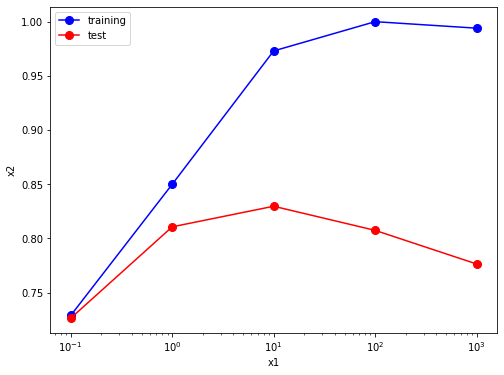

In [22]:
x_coordinates = C_list
x = np.stack((x_coordinates, C_train_accuracies))
x2 = np.stack((x_coordinates, C_test_accuracies))
y_ticks = [0, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0]
plt.figure(figsize = (8, 6))
plt.axes()
plt.xscale("log")

plt.yticks(ticks = y_ticks)
plt.xlabel("x1")
plt.ylabel("x2")
plt.plot(x[0], x[1],"-o", color = "blue", markersize = 8, label = "training")
plt.plot(x2[0], x2[1], "-o", color = "red",markersize = 8, label = "test")
plt.legend()
plt.show()